In [1]:
from thil_utils import *
torch.manual_seed(1000)
os.getcwd()
import argparse
today = datetime.date.today()


Using cuda device
Figure directory exists.
Model saving directory exists.


In [2]:
class SmokePlumeSegmentationDataset():
    def __init__(self, img_dir = None, seglbl=None, transform=None):
        self.transform = transform
        self.img_dir = img_dir
        self.imgfiles = []
        self.labels = []
        self.seglabels = []
        
        self.positive_indices = []
        self.negative_indices = []
        
        seglabels = []
        segfile_lookup = {}
        
        with open(seglbl) as jf:
            data = json.load(jf)
            
        for i, fl in enumerate(data):
            seglabels.append(fl)
            name = fl['data']['image'].split('/')[-1].split('-')[-1]
            segfile_lookup[name]=i
            
        idx = 0
        
        for root, dirs, files in os.walk(img_dir):
            for filename in files:
                if not filename.endswith('.jpg'):
                    continue
                if filename not in segfile_lookup.keys():
                    continue
                polygons = []
                for annotations in seglabels[segfile_lookup[filename]]['annotations']:
                    for result in annotations['result']:
                        polygons.append(
                            np.array(result['value']['points'] +
                                     [result['value']['points'][0]])*3)
                        
                if 'positive' in root and polygons != []:
                    self.labels.append(True)
                    self.positive_indices.append(idx)
                    self.imgfiles.append(os.path.join(root,filename))
                    self.seglabels.append(polygons)
                    idx +=1

        for root, dirs, files in os.walk(img_dir):
            for filename in files:
                if not filename.endswith('.jpg'):
                    continue
                if idx >= len(self.positive_indices)*2:
                    break
                if 'negative' in root:
                    self.labels.append(False)
                    self.negative_indices.append(idx)
                    self.imgfiles.append(os.path.join(root, filename))
                    self.seglabels.append([])
                    idx += 1
                    
        self.imgfiles = np.array(self.imgfiles)
        self.labels = np.array(self.labels)
        self.positive_indices = np.array(self.positive_indices)
        self.negative_indices = np.array(self.negative_indices)
   
    def __len__(self): return len(self.imgfiles)
    
    def __getitem__(self, idx):
        
        imgfile = rio.open(self.imgfiles[idx])
        imgdata = np.array([imgfile.read(i) for i in
                           [1,2,3]])
        fptdata = np.zeros(imgdata.shape[1:], dtype=np.uint8)      #creates 288x288 array of zeros

        polygons = self.seglabels[idx]
        shapes = []
        
        if len(polygons) > 0:
            for pol in polygons:
                try:
                    pol = Polygon(pol)
                    shapes.append(pol)
                except ValueError:
                    continue
                    
            fptdata = rasterize(((g, 1) for g in shapes),
                                    out_shape=fptdata.shape,
                                    all_touched=True)
        sample = {'idx': idx,
                  'img': imgdata,
                  'fpt': fptdata,
                  'imgfile': self.imgfiles[idx]}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def display(self, idx):
        """Helper method to display a given example from the data set with
        index `idx`. Only RGB channels are displayed, as well as the
        segmentation label outlines.
        :param idx: (int) image index to be displayed
        :param offset: (float) constant scaling offset (on a range [0,1])
        :param scaling: (float) scaling factor
        :return: `matplotlib.pyplot.figure` object
        """
        sample = self[idx]
        
        imgdata = sample['img'] #.permute(1, 2, 0)
        fptdata = sample['fpt']


        f, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(imgdata.T)
        ax[0].imshow(fptdata.T, alpha = 0.5)
        ax[1].imshow(imgdata.T)
        ax[1].axis('off')
        ax[0].axis('off')
        # plt.show()
        return f  
    
class Normalize(object):
    """Normalize pixel values to zero mean and range [-1, +1] measured in
    standard deviations."""
    def __init__(self):
        """
        :param size: edge length of quadratic output size
        """
        self.channel_means = np.array(
            [809.2, 900.5, 1061.4])
        self.channel_stds = np.array(
            [441.8, 624.7, 640.8])

    def __call__(self, sample):
        """
        :param sample: sample to be normalized
        :return: normalized sample
        """
        chan_0_mean = sample['img'][0].mean()
        chan_1_mean = sample['img'][1].mean()
        chan_2_mean = sample['img'][2].mean()

        chan_0_std = sample['img'][0].std()
        chan_1_std = sample['img'][1].std()
        chan_2_std = sample['img'][2].std()
        
        self.channel_means = np.array(
            [chan_0_mean, chan_1_mean, chan_2_mean])
        self.channel_stds = np.array(
            [chan_0_std, chan_1_std, chan_2_std])
        
        sample['img'] = (sample['img']-self.channel_means.reshape(
            sample['img'].shape[0], 1, 1))/self.channel_stds.reshape(
            sample['img'].shape[0], 1, 1)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        """
        :param sample: sample to be converted to Tensor
        :return: converted Tensor sample
        """

        out = {'idx': sample['idx'],
               'img': torch.from_numpy(sample['img'].copy()),
               'fpt': torch.from_numpy(sample['fpt'].copy()),
               'imgfile': sample['imgfile']}
        return out

class Randomize(object):
    """Randomize image orientation including rotations by integer multiples of
       90 deg, (horizontal) mirroring, and (vertical) flipping."""

    def __call__(self, sample):
        """
        :param sample: sample to be randomized
        :return: randomized sample
        """
        imgdata = sample['img']
        fptdata = sample['fpt']

        # mirror horizontally
        mirror = np.random.randint(0, 2)
        if mirror:
            imgdata = np.flip(imgdata, 2)
            fptdata = np.flip(fptdata, 1)
        # flip vertically
        flip = np.random.randint(0, 2)
        if flip:
            imgdata = np.flip(imgdata, 1)
            fptdata = np.flip(fptdata, 0)
        # rotate by [0,1,2,3]*90 deg
        rot = np.random.randint(0, 4)
        imgdata = np.rot90(imgdata, rot, axes=(1,2))
        fptdata = np.rot90(fptdata, rot, axes=(0,1))

        return {'idx': sample['idx'],
                'img': imgdata.copy(),
                'fpt': fptdata.copy(),
                'imgfile': sample['imgfile']}

    
def create_dataset(*args, apply_transforms=True, **kwargs):
    """Create a dataset; uses same input parameters as PowerPlantDataset.
    :param apply_transforms: if `True`, apply available transformations
    :return: data set"""
    if apply_transforms:
        data_transforms = transforms.Compose([
#             Normalize(),
#             RandomCrop(),
            Randomize(),
            ToTensor()
           ])
    else:
        data_transforms = None

    data = SmokePlumeSegmentationDataset(*args, **kwargs,
                                         transform=data_transforms)
    return data

In [3]:
batch_size = 32
    # create dataset
data_train = create_dataset(
    img_dir = '/hpc/home/srs108/thilafushi/images/train',
    seglbl='updated_segmentation_labels.json', 
    apply_transforms=True)
data_val = create_dataset(
    img_dir = '/hpc/home/srs108/thilafushi/images/val',
    seglbl= 'updated_segmentation_labels.json',
    apply_transforms=False)

train_dl = DataLoader(data_train, batch_size=batch_size,  shuffle=True, drop_last=True)
val_dl = DataLoader(data_val, batch_size=batch_size,  shuffle=False, drop_last=True)

In [8]:
t=0
for i in range(len(data_train)):
    if data_train[i]['imgfile'].split('/')[7] == 'negative':
        t+=1
        
print(t)

215


In [11]:
torch.tensor(215/478)

tensor(0.4498)

In [ ]:
# def train(model, loss, opt, epoch, device):
model                      = smp.Unet(encoder_name = 'resnet18', encoder_weights = 'imagenet', in_channels = 3,classes = 1)

model.train()

train_ious = []
train_fl = []

df = pd.DataFrame([])
running_loss = 0
running_acc = 0

for i, batch in tqdm(enumerate(train_dl)):
#     print(batch)
    x = batch['img'].float() #.to(device)
    y = batch['fpt'].float().unsqueeze(dim=1) #.to(device) #add dim 1
    print(y)
    output = model(x)
    print(output.shape)

#         a = mIoU(output, y, smooth=1e-10, n_classes=1)
#         print('miou',a)
    #Accuracy
    running_acc += pixel_accuracy(output, y)

    #Binary Cross Entropy Loss
    loss_epoch = loss(output, y)
    running_loss += loss_epoch.item()

    #IoU
    output_binary = np.zeros(output.shape)
    output_binary[output.cpu().detach().numpy() >= 0.5] = 1

    for j in range(y.shape[0]):
        z = jaccard_score(y[j].flatten().cpu().detach().numpy(),
                  output_binary[j][0].flatten())
        if (np.sum(output_binary[j][0]) != 0 and
            np.sum(y[j].cpu().detach().numpy()) != 0):
            train_ious.append(z)

    #Visual of predicted count of plume pixel vs true count of plume pixel
    for i in range(0,batch_size):
        df = df.append(pd.DataFrame({'Predicted': np.sum(output_binary[i]), 'Truth': np.sum(y[i].detach().numpy()),'set':'Train'}, index=[0]))

    opt.zero_grad()
    loss_epoch.backward(retain_graph=False)
    opt.step()

running_loss /= len(train_dl)

for i in range(1,4):
    image_comparison(batch['img'][-i], y[-i][0], output_binary[-i][0], epoch, save=True, train_o_test='Training', fig_name= 'Train_it_{}_ep'.format(i))
# return running_loss, np.average(train_ious),  running_acc/len(train_dl), df

0it [00:00, ?it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [6]:
def test(model, loss, scheduler, epoch, device):
    model.eval()

    running_loss = 0
    running_acc = 0
    df = pd.DataFrame([])

    test_ious = []
#     test_loss = []
    
    for j, batch in enumerate(val_dl):
        x = batch['img'].float().to(device)
        y = batch['fpt'].float().unsqueeze(dim=1).to(device)
        output = model(x)

        a = mIoU(output, y, smooth=1e-10, n_classes=1)
        
        #Accuracy
        running_acc += pixel_accuracy(output, y)
        
        #Binary Cross Entropy Loss
        loss_epoch = loss(output, y)
        running_loss += loss_epoch.item()

        #IoU
        output_binary = np.zeros(output.shape)
        output_binary[output.cpu().detach().numpy() >= 0] = 1

        for k in range(y.shape[0]):
            z = jaccard_score(y[k].flatten().cpu().detach().numpy(),
                      output_binary[k][0].flatten())
            if (np.sum(output_binary[k][0]) != 0 and
                np.sum(y[k].cpu().detach().numpy()) != 0):
                test_ious.append(z)

        for i in range(0,batch_size):
            df = df.append(pd.DataFrame({'Predicted': np.sum(output_binary[i]), 'Truth': np.sum(y[i].detach().numpy()), 'set':'Test'}, index=[0]))

    scheduler.step(running_loss/(j+1))
    torch.cuda.empty_cache()
#     print('Current Accuracy: ', running_acc/len(val_dl))
    
    for i in range(1,4):
        image_comparison(batch['img'][-i], y[-i][0], output_binary[-i][0], epoch, save=True,  train_o_test='Testing', fig_name='Test_it_{}_ep'.format(i))
    return running_loss/len(val_dl), np.average(test_ious),  running_acc/len(val_dl), df

In [8]:
def main(epochs, save_path):
    epochs                     = epochs
#     device                     = device
    lr                         = 1e-4
    model                      = smp.Unet(encoder_name = 'resnet18', encoder_weights = 'imagenet', in_channels = 3,classes = 1)
    model_name                 = 'saveme_' + str(today)+'_'+'.pt'
    best_iou                   = 1e9
    patience                   = 30
    trigger_times              = 0
    loss                       = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(18))
    opt                        = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler                  = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, threshold=lr, min_lr=1e-6)
    tests = []
    trains=[]
    
    train_iou = []
    test_iou = []
    
    acc_tr =[]
    acc_ts = []
    print('Training begins...')
    for epoch in range(1, epochs+1):
        
        train_loss, train_ious, train_acc, df_train = train(model, loss, opt, epoch, device)
        test_loss, test_ious, test_acc, df_test = test(model, loss, scheduler, epoch, device)
#         print(test_ious)

        if epoch % 5 == 0:
            total_v_pred(df_train, df_test, epoch)
    
        if test_ious > best_iou: #change to IoU?
            trigger_times += 1
            print('Triggered on epoch {}, best IoU: {}, current IoU: {} '.format(epoch, round(best_iou,3), round(test_ious,)))
            if trigger_times >= patience:
                print("Early stopping... best validation iou: ", best_iou)
                model.load_state_dict(best_model_dict)
                torch.save(best_model_dict, os.path.join(save_path, model_name))
                break
            
        else:
            trigger_times = 0 
            best_iou = test_ious
            best_model_dict = model.state_dict()
        
        current_epoch = epoch
            
        trains.append(train_loss)
        tests.append(test_loss)
        
        train_iou.append(train_ious)
        test_iou.append(test_ious)
        
        acc_tr.append(train_acc)
        acc_ts.append(test_acc)
        
#         print(current_epoch, len(trains), len(tests), len(train_iou), len(test_iou))
        
    return trains, tests, train_iou, test_iou, acc_tr, acc_ts, current_epoch


In [ ]:
save_path = model_root_dir+'/'+model_save_dir+'/'
start = time.time()
trains, tests, train_ious, test_ious, acc_tr, acc_ts, current_epoch = main(epochs=600, save_path= save_path)
stop = time.time()
print(f"Training time: {(stop - start)/3600}h")

0it [00:00, ?it/s]

Training begins...
{'idx': tensor([195,  82, 244, 451, 310, 367,   7, 202, 118, 295, 132, 358, 127, 449,
        231,  45, 394,  44,  28, 227, 216, 307, 215, 241, 147, 198, 193, 401,
        148,   1, 243, 156]), 'img': tensor([[[[ 42,  42,  35,  ...,  61,  57,  50],
          [ 40,  41,  37,  ...,  58,  57,  52],
          [ 41,  42,  39,  ...,  56,  61,  59],
          ...,
          [ 48,  47,  50,  ..., 201, 234, 235],
          [ 52,  53,  60,  ..., 202, 228, 225],
          [ 54,  55,  60,  ..., 224, 231, 193]],

         [[ 57,  58,  53,  ...,  85,  81,  76],
          [ 56,  57,  52,  ...,  82,  81,  78],
          [ 57,  58,  54,  ...,  80,  85,  83],
          ...,
          [ 64,  63,  69,  ..., 184, 212, 208],
          [ 68,  69,  79,  ..., 184, 206, 200],
          [ 70,  71,  79,  ..., 208, 211, 171]],

         [[ 54,  57,  53,  ...,  85,  81,  75],
          [ 55,  56,  55,  ...,  82,  81,  77],
          [ 56,  58,  57,  ...,  80,  85,  85],
          ...,
          [

In [27]:
def train_test_loss(loss_train, loss_test, epochs, save = True, fig_name=''):
    epoch = range(epochs)
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(epoch, loss_train, color='b', linewidth=0.5, label='Training')
    ax.plot(epoch, loss_test, color='r', linewidth=0.5, label='Testing')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Testing Loss')
    ax.legend()
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')

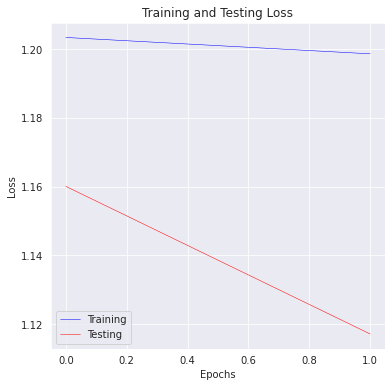

In [28]:
train_test_loss(trains, tests, current_epoch, save=True, fig_name='train_test_BCE_loss')


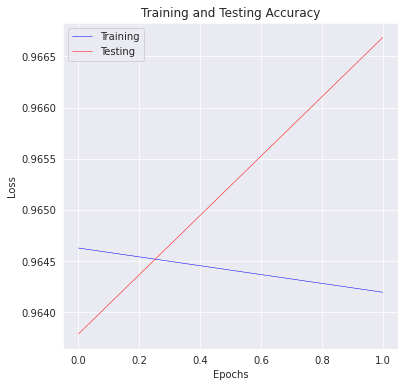

In [29]:
train_test_acc(acc_tr, acc_ts, current_epoch, save = True, fig_name='train_test_acc')

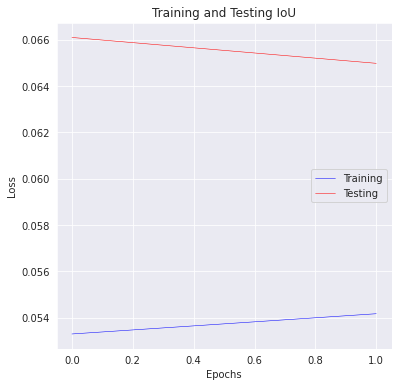

In [30]:
train_test_ious(train_ious, test_ious, current_epoch, save = True, fig_name='train_test_iou')

In [31]:
print('Best Train IoU:',max(train_ious))
print('Best Test IoU', max(test_ious))
print('Best Train Accuracy:', max(acc_tr))
print('Best Test Accuracy:', max(acc_ts))

Best Train IoU: 0.05417234713685342
Best Test IoU 0.06609944146665087
Best Train Accuracy: 0.9646267361111109
Best Test Accuracy: 0.9666858563207305


In [ ]:

#             axs[0,3].imshow(batch['img'][-1].permute(1, 2, 0), alpha=0.1)
#             f.text(0.74, 0.80, 'Train Loss: '+ str(round(running_loss/(i+1),4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
#             f.text(0.74, 0.76, 'Train IoU: ' + str(round(np.average(train_ious), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
#             f.text(0.74, 0.72, 'Train Acc: ' + str(round(running_acc/(i+1), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
#             f.text(0.74, 0.68, 'Train Focal: ' + str(round(running_fl/(i+1), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
#             axs[0,3].set_title("Metrics")
#             axs[0,3].axis('off')

In [ ]:
# def train_val(model, loss, opt, scheduler, epochs):

#     train_ious = []
#     train_loss = []
#     train_fl = []

#     val_ious = []
#     val_loss = []
#     val_fl = []

#     for epoch in range(epochs):
#         model.train()
        
#         df = pd.DataFrame([])
#         running_loss = 0
#         running_acc = 0
#         running_fl =0
        
#         for i, batch in tqdm(enumerate(train_dl), total=len(train_dl), desc='training'):
#             x = batch['img'].float()
#             y = batch['fpt'].float().unsqueeze(dim=1) #add dim 1
#             output = model(x)
            
#             #Accuracy
#             running_acc += pixel_accuracy(output, y)
            
#             #Focal Loss
#             running_fl += weighted_focal_loss(output,y, 0.7, 3).item()
            
#             #Binary Cross Entropy Loss
#             loss_epoch = loss(output, y)
#             running_loss += loss_epoch.item()
            
#             #IoU
#             output_binary = np.zeros(output.shape)
#             output_binary[output.cpu().detach().numpy() >= 0.5] = 1
        
#             for j in range(y.shape[0]):
#                 z = jaccard_score(y[j].flatten().cpu().detach().numpy(),
#                           output_binary[j][0].flatten())
#                 if (np.sum(output_binary[j][0]) != 0 and
#                     np.sum(y[j].cpu().detach().numpy()) != 0):
#                     train_ious.append(z)
        
            
#             #Visual of predicted count of plume pixel vs true count of plume pixel
#             for i in range(0,batch_size):
#                 df = df.append(pd.DataFrame({'Predicted': np.sum(output_binary[i]), 'Truth': np.sum(y[i].detach().numpy()),'set':'Train'}, index=[0]))
            
#             opt.zero_grad()
#             loss_epoch.backward(retain_graph=False)
#             opt.step()
            
#             image_comparison(batch['img'][-1], y[-1][0], output_binary[-1][0], epoch, save=True, fig_name='training_')

#         train_loss.append(running_loss/len(train_dl))
#         train_fl.append(running_fl/len(train_dl))
# # #evaluation______________________________________________________________________________________________________
#         model.eval()
    
#         running_loss_v = 0
#         running_acc_v = 0
#         running_fl_v = 0
#         df1 = pd.DataFrame([])

#         for j, batch_ in tqdm(enumerate(val_dl),total=len(val_dl), desc='validation'):
#             x = batch_['img'].float()
#             y_ = batch_['fpt'].float().unsqueeze(dim=1)
#             output = model(x)

#             #Accuracy
#             running_acc_v += pixel_accuracy(output, y_)
            
#             #Focal Loss
#             running_fl_v += weighted_focal_loss(output,y_, 0.7, 3).item()
            
#             #Binary Cross Entropy Loss
#             loss_epoch = loss(output, y_)
#             running_loss_v += loss_epoch.item()
            
#             #IoU
#             output_binary_val = np.zeros(output.shape)
#             output_binary_val[output.cpu().detach().numpy() >= 0] = 1
            
#             for k in range(y.shape[0]):
#                 z = jaccard_score(y_[k].flatten().cpu().detach().numpy(),
#                           output_binary_val[k][0].flatten())
#                 if (np.sum(output_binary_val[k][0]) != 0 and
#                     np.sum(y[k].cpu().detach().numpy()) != 0):
#                     val_ious.append(z)
                    
#             for i in range(0,batch_size):
#                 df1 = df1.append(pd.DataFrame({'Predicted': np.sum(output_binary_val[i]), 'Truth': np.sum(y_[i].detach().numpy()), 'set':'Val'}, index=[0]))

#         val_loss.append(running_loss_v/len(val_dl))
#         val_fl.append(running_fl_v/len(val_dl))
        
#         scheduler.step(running_loss_v/(j+1))
#         torch.cuda.empty_cache()
# #Plotting _________________________________________________________________________________________________________
        
# #         if epoch %40 ==0:
# #             f, axs = plt.subplots(2, 4, figsize=(10, 7))

# #             axs[0,0].imshow(batch['img'][-1].permute(1, 2, 0))                #original image, no labels
# #             axs[0,0].set_title('Original Image')
# #             axs[0,0].axis('off')

# #             axs[0,1].imshow(y[-1][0], alpha = 0.25)                           #ground truth label
# #             axs[0,1].set_title('Ground Truth Label')
# #             axs[0,1].axis('off')

# #             axs[0,2].imshow(output_binary[-1][0])                             #prediction
# #             axs[0,2].set_title('Training Prediction')
# #             axs[0,2].axis('off')

# #             axs[0,3].imshow(batch['img'][-1].permute(1, 2, 0), alpha=0.1)
# #             f.text(0.74, 0.80, 'Train Loss: '+ str(round(running_loss/(i+1),4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.76, 'Train IoU: ' + str(round(np.average(train_ious), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.72, 'Train Acc: ' + str(round(running_acc/(i+1), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.68, 'Train Focal: ' + str(round(running_fl/(i+1), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             axs[0,3].set_title("Metrics")
# #             axs[0,3].axis('off')

# #             axs[1,0].imshow(batch_['img'][-1].permute(1, 2, 0))               #original image, no labels
# #             axs[1,0].set_title('Original Image ')
# #             axs[1,0].axis('off')

# #             axs[1,1].imshow(y_[-1][0], alpha = 0.25)                          #ground truth label
# #             axs[1,1].set_title('Ground Truth Label')
# #             axs[1,1].axis('off') 

# #             axs[1,2].imshow(output_binary_val[-1][0])                          #prediction
# #             axs[1,2].set_title('Validation Prediction')
# #             axs[1,2].axis('off')

# #             axs[1,3].imshow(batch_['img'][-1].permute(1, 2, 0), alpha = 0.1)
# #             f.text(0.74, 0.38, 'Val Loss: '+str(round(running_loss_v/(i+1),4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.34, 'Val IoU: ' + str(round(np.average(val_ious), 4)),bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.30, 'Val Acc: ' + str(round(running_acc_v/(j+1), 4)), bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             f.text(0.74, 0.26, 'Val Focal: ' + str(round(running_fl_v/(j+1), 4)),bbox=dict(facecolor='black', alpha=0.5), color='white')
# #             axs[1,3].set_title("Metrics")
# #             axs[1,3].axis('off')
# #             f.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+'train_epoch__'+str(epoch)+'.png', transparent=False, facecolor='white', bbox_inches='tight')

# #             plt.show()
# #             plt.close() 
       
# #         if epoch % 40 == 0:
# #             plt.figure(figsize=(7,7))
# #             sns.set_style("darkgrid")
# #             conc = pd.concat([df, df1]).reset_index(drop=True)
# #             svm = sns.scatterplot(data=conc, x="Truth", y="Predicted", hue='set')
# #             svm.set_title("Predicted Plume Pixels vs. Total Plume Pixels")
# #             plt.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+'total_v_pred_'+str(epoch)+'.png', transparent=False, facebplor='white',bbox_inches='tight')
# #             plt.show()
# #             plt.close()
        
#         history = {'train_loss' : train_loss, 'val_loss': val_loss,
#         'train_miou':train_ious,'val_miou':val_ious,
#         'train_foc':train_fl,    'val_foc':val_fl}
        
#     return history